# ML projet - Groupe 3

# Pretraitement

In [125]:
import pandas as pd
from gensim.models import Word2Vec
import nltk
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import enchant
import numpy as np
from collections import Counter
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from sklearn.model_selection import KFold



from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

#nltk.download('punkt_tab')
#nltk.download("words")
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')
#%matplotlib qt
%matplotlib inline

In [126]:
df = pd.read_csv("scitweets_export.tsv", sep = "\t")

In [127]:
len(df[df["science_related"] == 0])/(len(df))

0.6710526315789473

In [128]:
#df[df["tweet_id"].duplicated()]

In [129]:
#df[df["text"].duplicated()]

In [130]:
#df[df["science_related"] == 0]

### Enlever (.,\\@#:';"“”’[]), les chiffres et les liens (http) de chaque tweet

In [131]:
text = []
all_text = list(df["text"])
for t in all_text:
    a = re.sub("[\.,/\\@:;\"\'0-9“”’\[\]]", "", t)
    a = re.sub("http\S*", "", a) #Enlever les liens
    a = re.sub("#\S*", "", a) #Enlever les tags
    a = a.lower()
    text.append(a)
#for sentence in text:  

In [132]:
#text

In [133]:
#Créer une liste des phrases ou chaque phrase est une liste de mots.
text_sep = [word_tokenize(t) for t in text]

In [134]:
#len(text_sep)
text_sep[-3]

['whats', 'the', 'uber', 'support', 'team', 'email', 'address', '?']

## Standardizer chaque phrases. 
- Convertir les noms pluriels en leur forme singuliers
- Convertir les conjugaison de chaque verbe en leur infinitif
- Standardiser les ajectives et les adverbes

In [135]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):  # Adjectif
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verbe
        return wordnet.VERB
    elif tag.startswith('N'):  # Nom
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverbe
        return wordnet.ADV
    else:
        return wordnet.NOUN 

    
lemmatizer = WordNetLemmatizer()
refined_tweets = []
for tweet in text_sep:
    pos_tags = pos_tag(tweet)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    refined_tweets.append(lemmatized_words)



In [136]:
refined_tweets_join = []
phrase = ""

for sentence in refined_tweets:
    for word in sentence:
        phrase = phrase + word + " "
    refined_tweets_join.append(phrase)
    phrase = ""

len(refined_tweets_join)

1140

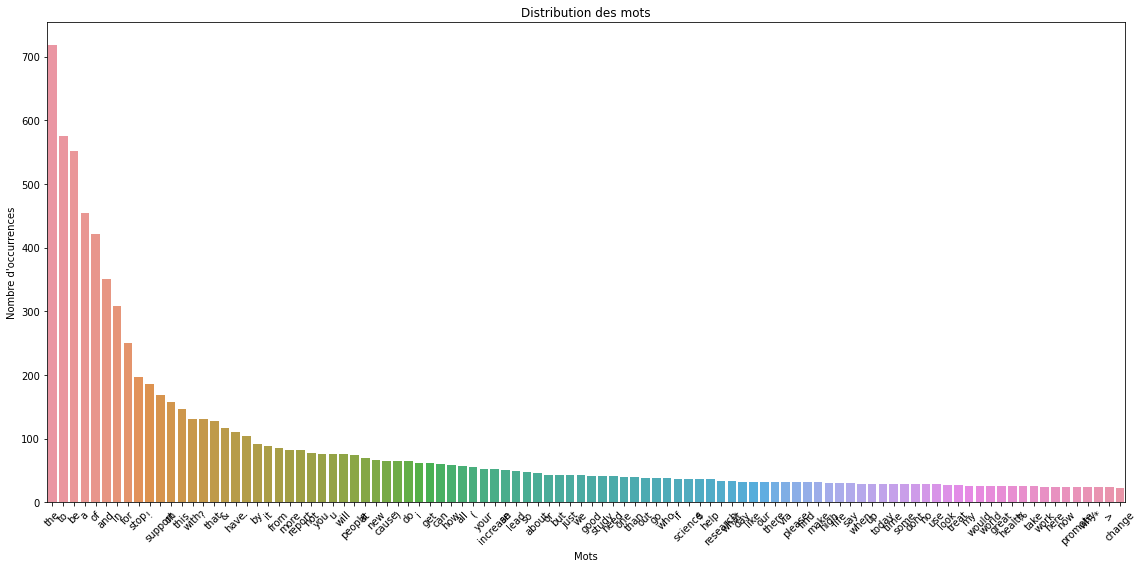

In [142]:
refined_tweets_flat = [word for sublist in refined_tweets for word in sublist]

word_counts = Counter(refined_tweets_flat)

# 3. Afficher les 10 mots les plus fréquents (optionnel)
most_common = word_counts.most_common(100)
words, counts = zip(*most_common)

# 4. Tracer avec seaborn
#plt.figure(figsize=(30, 12))
plt.figure(figsize=(16, 8)).gca()
sns.barplot(x=list(words), y=list(counts))
plt.title("Distribution des mots")
plt.ylabel("Nombre d'occurrences")
plt.xlabel("Mots")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [137]:
X = refined_tweets_join  # Utiliser uniquement la colonne 'text' comme feature
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)

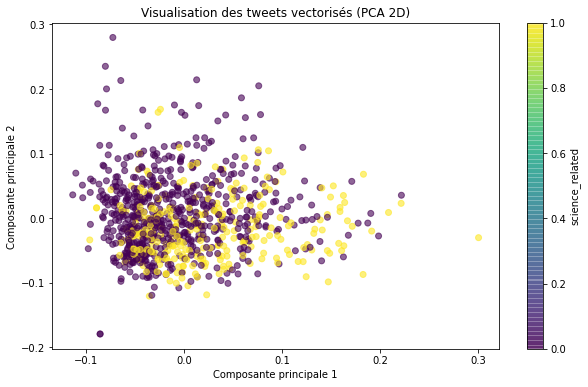

In [138]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduire la dimension à 2D avec PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_vec.toarray())  # Convertir la matrice creuse en tableau dense

# Visualiser les données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (PCA 2D)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

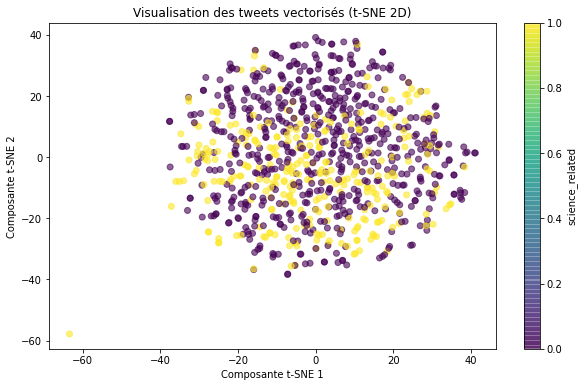

In [139]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduire la dimension à 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_vec.toarray())

# Visualiser les données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (t-SNE 2D)')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.show()

In [140]:
X_train_vec.data

array([0.66143791, 0.62378975, 0.41639673, ..., 0.14487836, 0.1550226 ,
       0.06634799])

In [141]:
ind = 103
print(text_sep[ind], "\n")
print(refined_tweets[ind])

['we', 'specialise', 'in', 'providing', 'the', 'modular', 'ground', 'study', 'courses', 'required', 'to', 'convert', 'your', 'icao', 'professional'] 

['we', 'specialise', 'in', 'provide', 'the', 'modular', 'ground', 'study', 'course', 'require', 'to', 'convert', 'your', 'icao', 'professional']


In [68]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):  # Adjectif
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verbe
        return wordnet.VERB
    elif tag.startswith('N'):  # Nom
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverbe
        return wordnet.ADV
    else:
        return wordnet.NOUN 

    
lemmatizer = WordNetLemmatizer()
refined_tweets = []
for tweet in text_sep:
    pos_tags = pos_tag(tweet)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    refined_tweets.append(lemmatized_words)



In [69]:
refined_tweets_join = []
phrase = ""

for sentence in refined_tweets:
    for word in sentence:
        phrase = phrase + word + " "
    refined_tweets_join.append(phrase)
    phrase = ""

len(refined_tweets_join)

1140

### Le code desous montre que 70% de mots dans les tweet sont valide (dans les dictionnaire anglais)

In [70]:
valid_words = []
invalid_words = []

d = enchant.Dict("en_US")

#Trouver tous les mots qui sont dans la dictionnaiore anglais 
for sentence in refined_tweets:
    for w in sentence:
        if w not in valid_words:
            if d.check(w):
                valid_words.append(w)
            if d.check(w.capitalize()) and w not in valid_words:
                valid_words.append(w)
                
            
total_words = []
for sentence in refined_tweets:
    for w in sentence:
        if w not in total_words:
            total_words.append(w)

            
print(len(valid_words)/len(total_words))


0.7057108557708798


In [71]:
invalid_words = []
for sentence in refined_tweets:
    for w in sentence:
        if w not in invalid_words:
            if w not in valid_words:
                invalid_words.append(w)
#invalid_words

In [72]:
refined_tweets

[['knee',
  'be',
  'a',
  'bit',
  'sore',
  'i',
  'guess',
  'thats',
  'a',
  'sign',
  'that',
  'my',
  'recent',
  'treadmilling',
  'be',
  'work'],
 ['mcdonalds', 'breakfast', 'stop', 'then', 'the', 'gym', '🏀💪'],
 ['can',
  'any',
  'gynecologist',
  'with',
  'cancer',
  'experience',
  'explain',
  'the',
  'danger',
  'of',
  'transvaginal',
  'douching',
  'with',
  'fluoride',
  'or',
  'other',
  'toxin',
  'such',
  'a',
  'dioxin',
  '?'],
 ['couch-lock',
  'high',
  'lead',
  'to',
  'sleep',
  'in',
  'the',
  'couch',
  'get',
  'ta',
  'stop',
  'do',
  'this',
  'shit'],
 ['do',
  'daily',
  'routine',
  'help',
  'prevent',
  'problem',
  'with',
  'bipolar',
  'disorder'],
 ['the',
  'impact',
  'of',
  'infertility',
  'on',
  'you',
  'and',
  'your',
  'relationship'],
 ['traffic',
  'jam',
  'in',
  'brain',
  'neuron',
  'could',
  'be',
  'cause',
  'of',
  'statin-related',
  'cognitive',
  'decline'],
 ['can',
  'play',
  'more',
  'game',
  'improve',
 

In [76]:
len(refined_tweets_flat)

20517

In [103]:
refined_tweets_flat = [word for sublist in refined_tweets for word in sublist]

word_counts = Counter(refined_tweets_flat)

# 3. Afficher les 10 mots les plus fréquents (optionnel)
most_common = word_counts.most_common(100)
words, counts = zip(*most_common)

# 4. Tracer avec seaborn
#plt.figure(figsize=(30, 12))
plt.figure(figsize=(16, 8)).gca()
sns.barplot(x=list(words), y=list(counts))
plt.title("Distribution des mots")
plt.ylabel("Nombre d'occurrences")
plt.xlabel("Mots")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [106]:
len(Counter(refined_tweets_flat).keys())

5831

In [107]:
700/5831

0.12004801920768307

### Vectoriser les mots

In [24]:
len(model.wv["science"])

NameError: name 'model' is not defined

In [ ]:
len(refined_tweets)

In [ ]:
s = "a " + "a"
s+= " b"
s

In [25]:
#import numpy as np
#from sklearn.feature_extraction.text import TfidfVectorizer

# Exemple de corpus (phrases en texte brut)
sentences = [
    "The scientific discovery was groundbreaking",
    "Physics and chemistry are fundamental sciences",
    "The research paper introduced a new concept"
]

# Étape 1: Calculer le TF-IDF sur toutes les phrases
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(refined_tweets_join)
tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

# Simulons un modèle Word2Vec où chaque mot est représenté par un vecteur de taille 200
# (En pratique, tu utiliserais un vrai modèle Word2Vec comme gensim)
word2vec_model = model.wv

# Fonction pour convertir une phrase en un vecteur TF-IDF pondéré
def sentence_to_tfidf_w2v(sentence):
    words = sentence.split()  # Tokenisation simple (mieux vaut utiliser nltk/spacy)
    vectors = []
    weights = []
    
    for word in words:
        if word in word2vec_model and word in tfidf_scores:  # Vérifier si le mot a un vecteur
            vectors.append(word2vec_model[word] * tfidf_scores[word])  # Pondérer par TF-IDF
            weights.append(tfidf_scores[word])

    if len(vectors) == 0:  # Si aucun mot n'a de vecteur, renvoyer un vecteur nul
        return np.zeros(200)
    
    return np.sum(vectors, axis=0) / np.sum(weights)  # Moyenne pondérée

# Transformer chaque phrase en un vecteur de taille 200
X_transformed = np.array([sentence_to_tfidf_w2v(sentence) for sentence in refined_tweets_join])


NameError: name 'model' is not defined

In [26]:
len(X_transformed)

NameError: name 'X_transformed' is not defined

In [27]:
df

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1135,1255,1340455669443350528,@LaylaFanucci @realDonaldTrump I'm sorry but w...,1,1.0,0.0,0.0
1136,1256,1340689510569549824,"Dear #NIN applicants, you can kindly download ...",0,0.0,0.0,0.0
1137,1258,1341155832793165825,Whats the uber support team email address?,0,0.0,0.0,0.0
1138,1259,1344167355648241664,House passes bill to increase stimulus checks ...,0,0.0,0.0,0.0


In [102]:
df["science_related"]

0       0
1       0
2       1
3       1
4       1
       ..
1135    1
1136    0
1137    0
1138    0
1139    0
Name: science_related, Length: 1140, dtype: int64

In [159]:
data_vec = list(zip(X_transformed, df["science_related"]))

In [160]:
random.shuffle(data_vec)

train_quantity  = 0.8

train_data = data_vec[0:int(len(data_vec)*0.8)]
test_data = data_vec[int(len(data_vec)*0.8)::]

x = [val[0] for val in data_vec]
y = [val[1] for val in data_vec]

x_train = [val[0] for val in train_data]
y_train = [val[1] for val in train_data]


x_test = [val[0] for val in test_data]
y_test = [val[1] for val in test_data]


clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# SVM
svm = SVC(kernel="rbf")
svm.fit(x_train, y_train)

SVC()

In [162]:
len(x)

1140

In [163]:
scores = cross_val_score(svm, x, y, scoring='accuracy', cv=10, n_jobs=-1)
scores

array([0.6754386 , 0.6754386 , 0.6754386 , 0.6754386 , 0.6754386 ,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667])

In [154]:
y_pred_rf = clf.predict(x_test)

# Prédictions avec SVM
y_pred_svm = svm.predict(x_test)

In [153]:
# Évaluation Random Forest
print("Performance du Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Évaluation SVM
print("\nPerformance du SVM:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Performance du Random Forest:
              precision    recall  f1-score   support

           0       0.68      0.98      0.81       156
           1       0.25      0.01      0.03        72

    accuracy                           0.68       228
   macro avg       0.47      0.50      0.42       228
weighted avg       0.55      0.68      0.56       228

Accuracy: 0.6754385964912281

Performance du SVM:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       156
           1       0.00      0.00      0.00        72

    accuracy                           0.68       228
   macro avg       0.34      0.50      0.41       228
weighted avg       0.47      0.68      0.56       228

Accuracy: 0.6842105263157895


/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking

# Convertir chaque phrase en une séquence de vecteurs Word2Vec
def vectorize_sentence(sentence, model, max_length=20):
    words = sentence
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    # Padding avec des zéros si la phrase est trop courte
    while len(word_vectors) < max_length:
        word_vectors.append(np.zeros(model.vector_size))
    
    # Troncature si trop long
    return np.array(word_vectors[:max_length])

word_model = []
for sentence in refined_tweets:
    a = vectorize_sentence(sentence, model)
    word_model.append(a)

# Créer les données sous forme de séquences de vecteurs
#X = np.array([vectorize_sentence(text, word2vec_model) for text in df["text"]])
X = np.array(word_model)

y = df["science_related"].values

# Définir le modèle LSTM
model = Sequential([
    Masking(mask_value=0.0, input_shape=(20, model.vector_size)),  # Ignorer les zéros
    LSTM(128, return_sequences=False),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")  # Classification binaire
])

# Compilation et entraînement
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, y, epochs=10, batch_size=16, validation_split=0.2)


2025-03-24 10:54:59.100599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-24 10:54:59.100641: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-24 10:55:02.356933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-24 10:55:02.356968: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-24 10:55:02.357008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc): /proc/driver/nvidia/version does not exist
2025-03-24 10:55:02.357472: I tensorflow/core/platform/cpu_feature_guard.c

Epoch 1/10
57/57 [==============================] - 7s 55ms/step - loss: 0.6387 - accuracy: 0.6689 - val_loss: 0.6756 - val_accuracy: 0.6535
Epoch 2/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6315 - accuracy: 0.6754 - val_loss: 0.6541 - val_accuracy: 0.6535
Epoch 3/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6321 - accuracy: 0.6754 - val_loss: 0.6490 - val_accuracy: 0.6535
Epoch 4/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6296 - accuracy: 0.6754 - val_loss: 0.6476 - val_accuracy: 0.6535
Epoch 5/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6279 - accuracy: 0.6754 - val_loss: 0.6453 - val_accuracy: 0.6535
Epoch 6/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6293 - accuracy: 0.6754 - val_loss: 0.6489 - val_accuracy: 0.6535
Epoch 7/10
57/57 [==============================] - 2s 27ms/step - loss: 0.6295 - accuracy: 0.6754 - val_loss: 0.6504 - val_accuracy: 0.6535
Epoch 8/10
57